# **Project Name**    - Wine Classification (multiclass)
##### **Data**            - https://archive.ics.uci.edu/dataset/109/wine

This script performs data analysis, feature engineering, and classification for the Wine dataset.
Includes Logistic Regression and Random Forest classifiers with hyperparameter tuning.
The selected models aim to explore both linear and non-linear relationships in the data.

**Steps Performed for  ML Model Implementation:**

> Step 1: Loading and Understanding

> Step 2: Exploratory data analysis EDA

> Step 3: ML Model assumption and checks

> Step 4: Feature selection - Dimensionality Reduction

> Step 5: Model Validation & Evaluation

#Imports

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

In [2]:
# Suppress specific UserWarnings during grid search
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#Data load

In [3]:
def load_data(file_path):
    """Load the dataset from a specified file path."""
    try:
        df = pd.read_csv(file_path, index_col=0)
        feature_names = df.columns
        return df, feature_names
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [4]:
file_path = 'https://raw.githubusercontent.com/Zanyata/Wine-Classifier/refs/heads/main/data/wine.csv'
df, feature_names = load_data(file_path)

#EDA

In [ ]:
def perform_eda(df):
    """Perform exploratory data analysis and visualize key insights."""
    print("Dataset Duplicates:")
    print(df.duplicated().unique())

    print("\nDataset Info:")
    print(df.info())

    print("\nSample Data:")
    print(df.sample(5))

    print("\nStatistical Summary:")
    print(df.describe())

    print("\nCorrelation Matrix:")
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Feature Correlation")
    plt.show()

    print("\nClass Distribution:")
    visualiser = ClassBalance()
    visualiser.fit(df.index)
    visualiser.show()

In [ ]:
def visualize_outliers(df):
    """Visualize outliers using boxplots after scaling."""
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    print("\nOutliers Distribution:")
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=df_scaled, orient="h")
    plt.title("Boxplot of Scaled Numeric Features")
    plt.show()

Dataset Duplicates:
[False]

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 1 to 3
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity of ash             178 non-null    float64
 4   magnesium                     178 non-null    int64  
 5   total phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  OD280/OD315 of diluted wines  178 non-null    float64
 12  proline                     

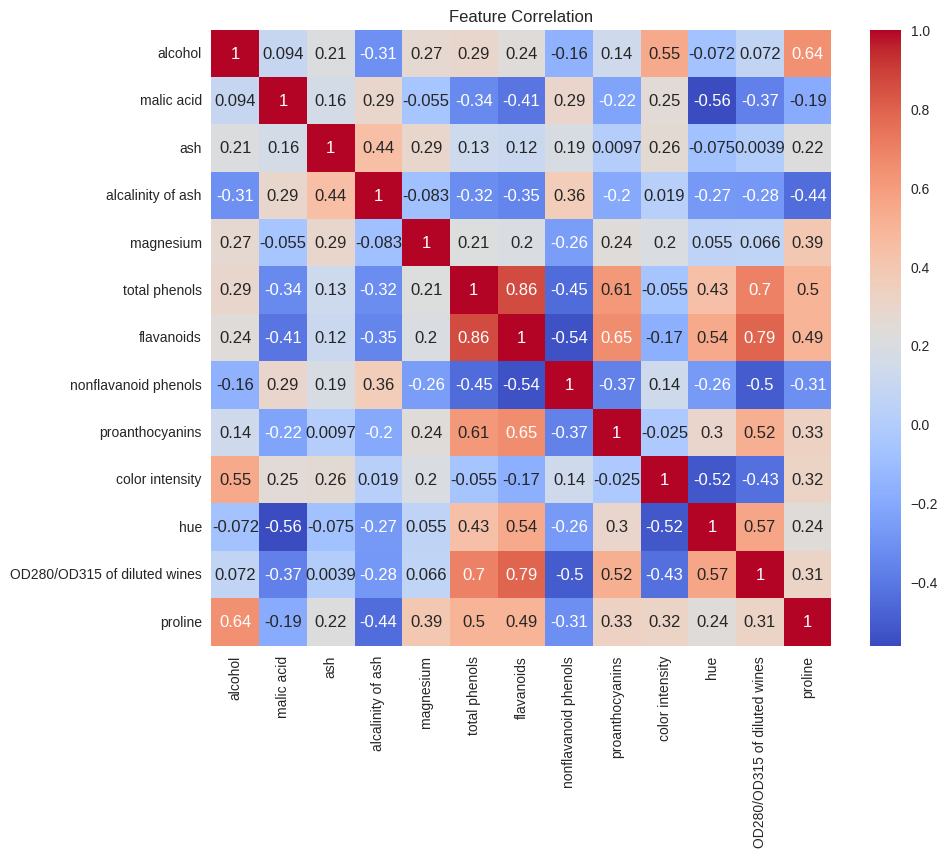


Class Distribution:


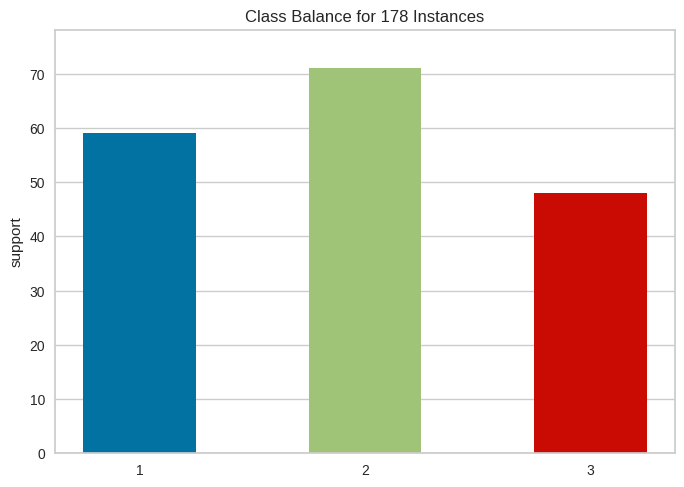

In [ ]:
perform_eda(df)

There is no null data, and no duplicates. Some features have high correlation which shows good potential for ML analysis.

3 labels - fairly well balanced.


Outliers Distribution:


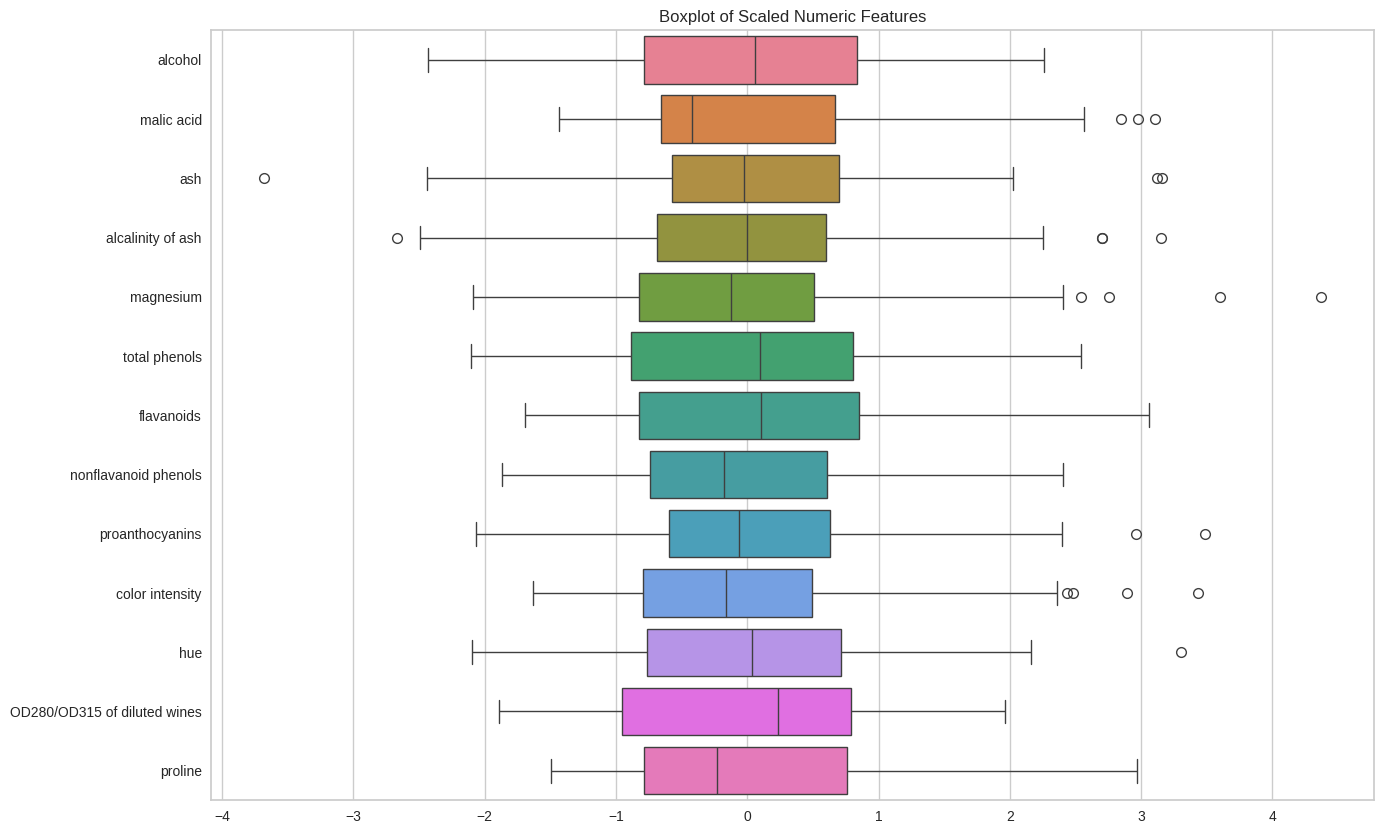

In [ ]:
visualize_outliers(df)

Ignoring statistical outliers as there is no high outliers value or their concentration. Since we have a small dataset and outliers will be present in real-life data, they should be left, if ML algorithms can manage them.

#Data split

In [5]:
def split_data(df):
    """Split data into train and test sets using stratified sampling."""
    df_set = df.reset_index()
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(df_set, df_set["label"]):
        strat_train_set = df_set.iloc[train_index]
        strat_test_set = df_set.iloc[test_index]

    X_train = strat_train_set.drop(columns=["label"]).values
    y_train = strat_train_set["label"].values
    X_test = strat_test_set.drop(columns=["label"]).values
    y_test = strat_test_set["label"].values

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split_data(df)

#ML

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate the model's performance on train and test sets."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\nTrain Set Metrics:")
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Precision:", precision_score(y_train, y_train_pred, average='weighted'))
    print("Recall:", recall_score(y_train, y_train_pred, average='weighted'))
    print("F1 Score:", f1_score(y_train, y_train_pred, average='weighted'))

    print("\nTest Set Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))

    print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

    # Visualize Confusion Matrix
    confusion_matrix(model, X_train, y_train, X_test, y_test)
    plt.tight_layout()
    plt.show()

In [10]:
def logistic_regression_pipeline(X_train, y_train):
    """Train Logistic Regression model with Grid Search.
    Logistic Regression was chosen as a baseline due to its interpretability and efficiency
    in handling linearly separable data. It aims to test its robustness on the dataset.
    """
    pipe = Pipeline([
        ("sc", StandardScaler()),
        ("log", OneVsRestClassifier(LogisticRegression()))  # Explicitly use OneVsRestClassifier
    ])

    param_grid = {
        "log__estimator__penalty": ["l1", "l2", "elasticnet"],
        "log__estimator__C": [0.01, 0.05, 0.1],
        "log__estimator__l1_ratio": [0.05, 0.1, 0.5],
        "log__estimator__max_iter": [500],
        "log__estimator__solver": ["saga"],
        "log__estimator__tol": [1e-6, 1e-5],
    }

    folds = KFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=folds,
        scoring="accuracy",
        return_train_score=True,
        refit=True,
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Logistic Regression Params: {grid_search.best_params_}")
    return grid_search.best_estimator_, grid_search.best_params_



--- Logistic Regression ---
Best Logistic Regression Params: {'log__estimator__C': 0.1, 'log__estimator__l1_ratio': 0.05, 'log__estimator__max_iter': 500, 'log__estimator__penalty': 'l2', 'log__estimator__solver': 'saga', 'log__estimator__tol': 1e-06}

Train Set Metrics:
Accuracy: 0.9929577464788732
Precision: 0.9931383170819791
Recall: 0.9929577464788732
F1 Score: 0.9929723149840314

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report (Train):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      0.98      0.99        57
           3       0.97      1.00      0.99        38

    accuracy                           0.99       142
   macro avg       0.99      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142


Classification Report (Test):
               precision    recall  f1-score   support

           1       1.00      1.00    

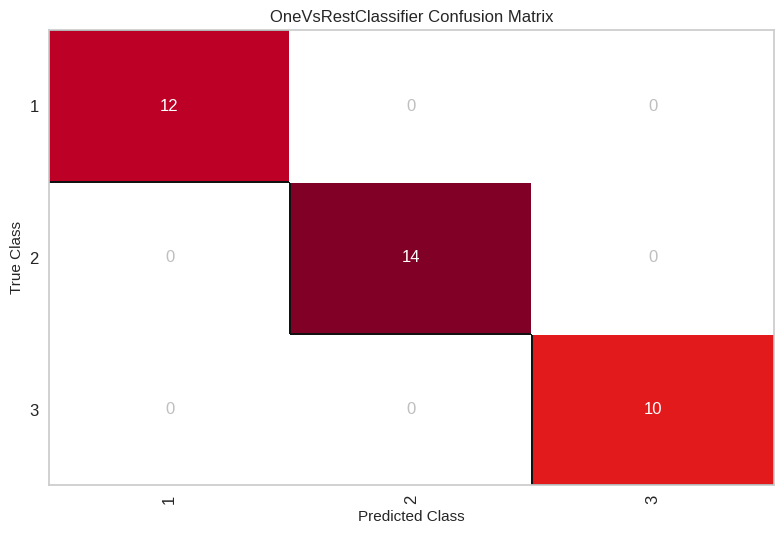

<Figure size 800x550 with 0 Axes>

In [11]:
print("\n--- Logistic Regression ---")
best_log_model, best_log_params = logistic_regression_pipeline(X_train, y_train)
evaluate_model(best_log_model, X_train, y_train, X_test, y_test)

Great test metrics for Logistic Regression model. Since it is the simplest model that can be implemented for this type of data, there is no need for further model search.

 **Feature selection**

 For further enhancement in so well balanced dataset, we might use feature importances from Random Forest. It measures the total reduction of the Gini impurity of the dataset, when a particular feature is used for splitting. Let's try to perform **dimensionality reduction** - reduce features qty, which will save time and computational resources for future analysis.

 This step was chosen instead of using coefficients, because it may capture interactions or non-linear relationships, which Logistic Regression can't handle.

In [ ]:
def random_forest_pipeline(X_train, y_train):
    """Train Random Forest model with Grid Search.
    Random Forest was selected to capture non-linear relationships and provide insights
    into feature importance. This is particularly useful for datasets with complex interactions.
    """
    pipe = Pipeline([
        ("sc", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])

    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 25],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 4],
        'rf__max_features': ['sqrt', 'log2'],
    }

    folds = KFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=folds,
        scoring="accuracy",
        return_train_score=True,
        refit=True,
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Random Forest Params: {grid_search.best_params_}")

    return grid_search.best_estimator_, grid_search.best_params_


--- Random Forest ---
Best Random Forest Params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

Train Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report (Train):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142


Classification Report (Test):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    a

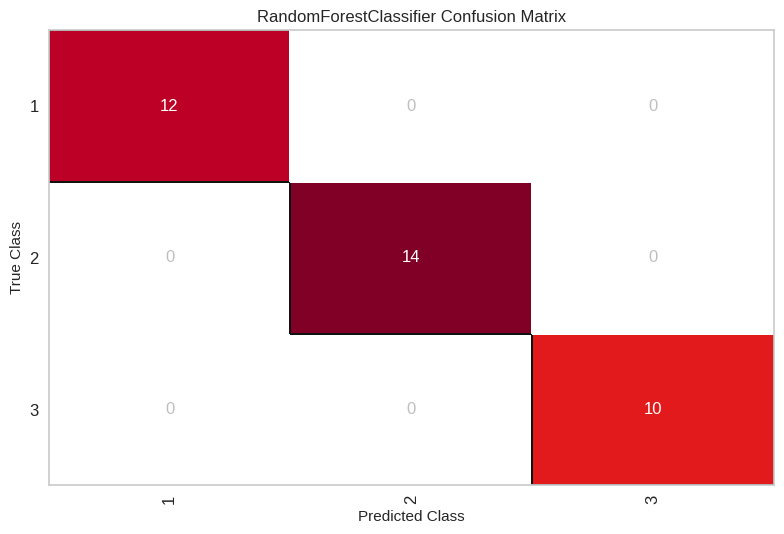

<Figure size 800x550 with 0 Axes>

In [ ]:
print("\n--- Random Forest ---")
best_rf_model, best_rf_params = random_forest_pipeline(X_train, y_train)
evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)

In [ ]:
# Feature Importance Analysis

def feature_importance(best_rf_model, feature_names):
  # Access the RandomForestClassifier step within the pipeline
  rf_model = best_rf_model.named_steps['rf']

  # Get feature importances from the RandomForestClassifier
  importances = rf_model.feature_importances_

  feature_importance_dict = dict(zip(feature_names, importances))

  # Sort feature importances in descending order
  sorted_importances = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

  plt.barh(range(len(sorted_importances)), sorted_importances.values(), align='center', tick_label= list(sorted_importances.keys()))
  plt.xlabel("Importance Score")
  plt.ylabel("Features")
  plt.title("Feature Importances in Random Forest")
  plt.gca().invert_yaxis()
  plt.show()

  return sorted_importances

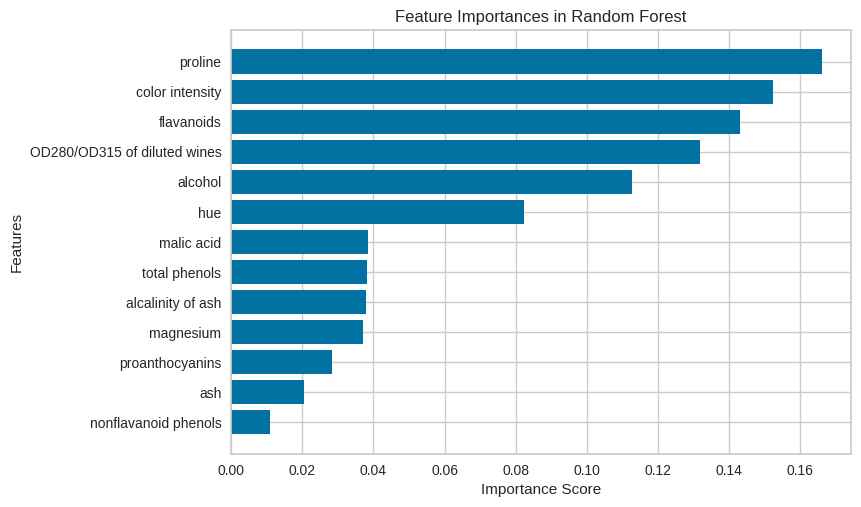

In [ ]:
sorted_importances = feature_importance(best_rf_model, feature_names)

In [ ]:
# Preparing dataset for dimensionality reduction based on feature importance
def dim_reduction(sorted_importances):
  filtered_importances = {feature: importance for feature, importance in sorted_importances.items() if importance > 0.075}
  filtered_list = list(filtered_importances.keys())
  df_dim_reduction = df[filtered_list].copy()

  X_train_dim_reduction, X_test_dim_reduction, y_train_dim_reduction, y_test_dim_reduction = split_data(df_dim_reduction)

  return X_train_dim_reduction, X_test_dim_reduction, y_train_dim_reduction, y_test_dim_reduction

In [ ]:
X_train_dim_reduction, X_test_dim_reduction, y_train_dim_reduction, y_test_dim_reduction = dim_reduction(sorted_importances)

In [ ]:
#Logistic Regression with Dimensionality Reduction

def dim_reduction_logistic_regression(best_log_params):
  log_params = best_log_params.copy()
  log_params = {key.replace('estimator__log__', ''): value for key, value in log_params.items()}

  # Create a new pipeline or classifier using best parameters
  new_pipe = Pipeline([
      ("sc", StandardScaler()),  # Use the same scaler or preprocessors
      ("log", LogisticRegression(**log_params))  # Initialize with best hyperparameters
  ])

  # Wrap it in OneVsRestClassifier
  new_ovr_pipe = OneVsRestClassifier(new_pipe)

  # Train the new model
  new_ovr_pipe.fit(X_train_dim_reduction, y_train_dim_reduction)

  evaluate_model(new_ovr_pipe, X_train_dim_reduction, y_train_dim_reduction, X_test_dim_reduction, y_test_dim_reduction)



Train Set Metrics:
Accuracy: 0.9859154929577465
Precision: 0.9862427771758758
Recall: 0.9859154929577465
F1 Score: 0.9858725318417683

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report (Train):
               precision    recall  f1-score   support

           1       0.98      1.00      0.99        47
           2       1.00      0.96      0.98        57
           3       0.97      1.00      0.99        38

    accuracy                           0.99       142
   macro avg       0.98      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142


Classification Report (Test):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       

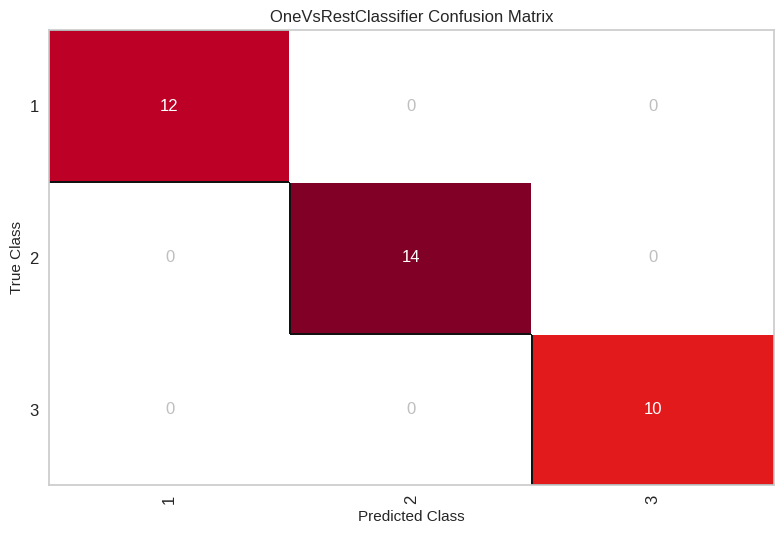

<Figure size 800x550 with 0 Axes>

In [ ]:
dim_reduction_logistic_regression(best_log_params)

#Conclusion

We see that leaving 6 most important features:

'color intensity',

'proline',

'flavanoids',

'alcohol',

'OD280/OD315 of diluted wines',

'hue',

was sufficient to preserve very good metrics.


**Best Logistic Regression Params:** {'estimator__log__C': 0.1, 'estimator__log__l1_ratio': 0.05, 'estimator__log__max_iter': 500, 'estimator__log__penalty': 'l2', 'estimator__log__solver': 'saga', 'estimator__log__tol': 1e-06}


>**ML Model selected for deployment: Logistic regression**


**Advantages**
* Logistic regression is easy to implement, interpret, and very efficient to train.
* It can easily extend to multiple classes(multinomial regression).
* It is very fast at classifying unknown records.
* It can interpret model coefficients as indicators of feature importance.
* Logistic regression is less inclined to over-fitting but it can overfit in high dimensional datasets. One may consider Regularization (L1 and L2) techniques to avoid over-fitting in these scenarios.

**Disadvantages:**

*  If the number of observations is lesser than the number of features, Logistic Regression should not be used, otherwise, it may lead to overfitting.
* The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables.
* Logistic Regression requires average or no multicollinearity between independent variables.
